In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal=sns.color_palette()

In [ ]:
df= pd.read_csv('/content/PJME_hourly.csv')
df= df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

<Axes: title={'center': 'PJME Hourly Consumption'}, xlabel='Datetime'>

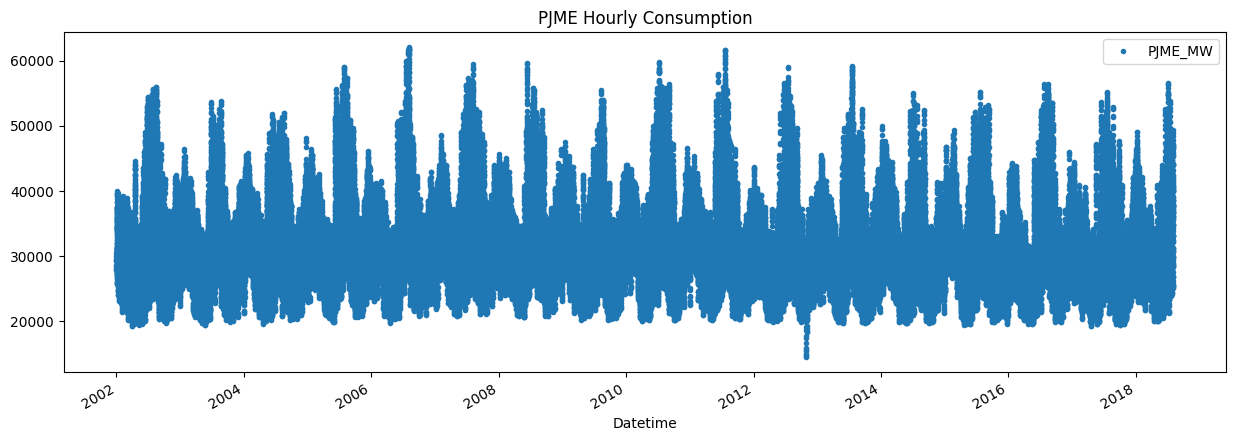

In [ ]:
df.plot(style='.', figsize=(15,5),color=color_pal[0], title='PJME Hourly Consumption')

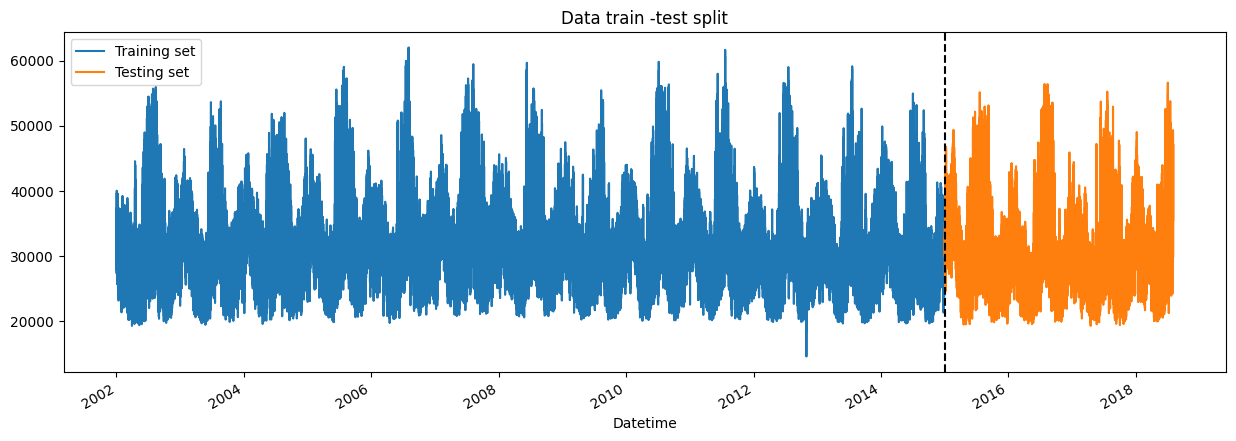

In [ ]:
train=df.loc[df.index < '01-01-2015']
test=df.loc[df.index >= '01-01-2015']
fig, ax =plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training set',title='Data train -test split')
test.plot(ax=ax, label='Testing set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training set','Testing set'])
plt.show()

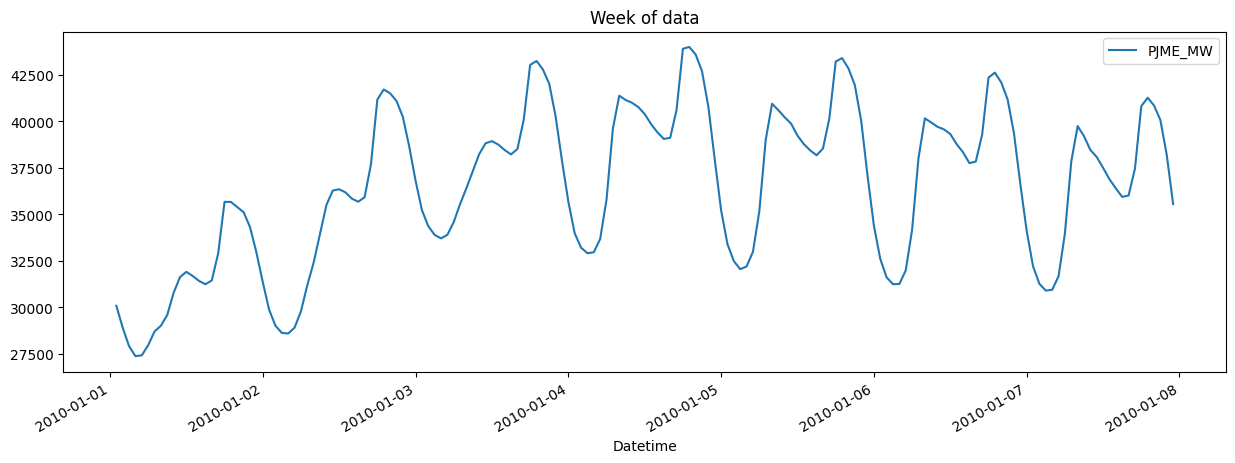

In [ ]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize=(15,5),title='Week of data')
plt.show()


In [ ]:
#Feature Creation
def create_features(df):
  df=df.copy()
  df['hour']= df.index.hour
  df['dayofweek']=df.index.dayofweek
  df['quarter']=df.index.quarter
  df['month']=df.index.month
  df['year']=df.index.year
  df['dayofyear']=df.index.dayofyear
  return df

In [ ]:
df=create_features(df)

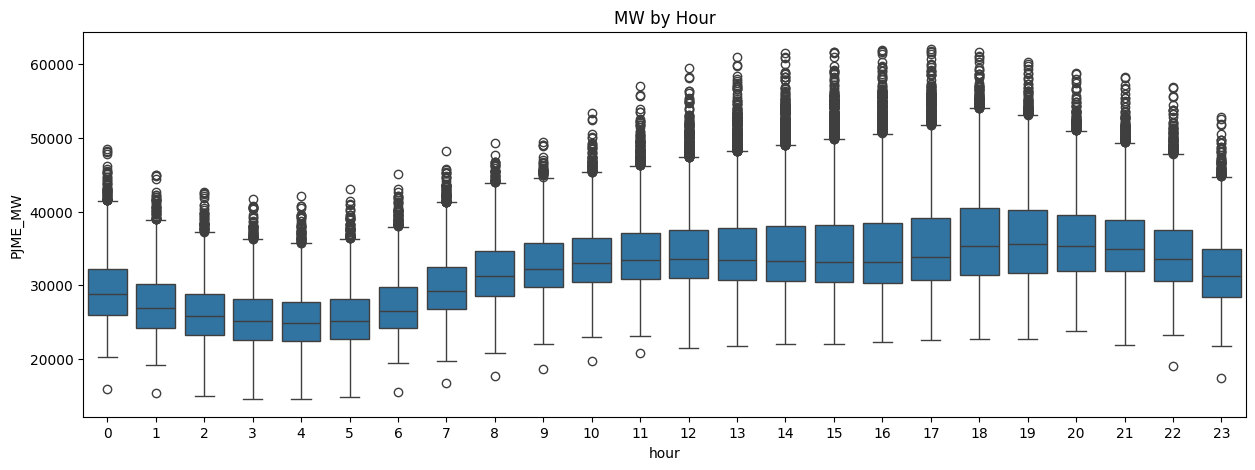

In [ ]:
#Visualize the feature-target relationship
fig,ax=plt.subplots(figsize=(15,5))
sns.boxplot(data=df, x='hour',y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

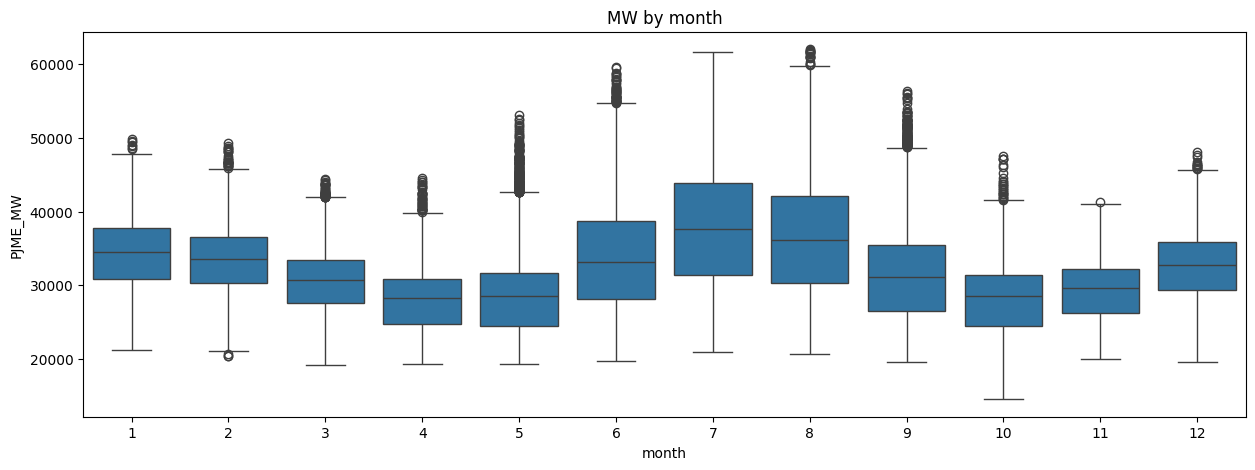

In [ ]:
fig,ax=plt.subplots(figsize=(15,5))
sns.boxplot(data=df, x='month',y='PJME_MW')
ax.set_title('MW by month')
plt.show()

In [ ]:
#Create our model
train=create_features(train)
test=create_features(test)
FEATURES=['hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear']
TARGET=['PJME_MW']

In [ ]:
x_train=train[FEATURES]
y_train=train[TARGET]
x_test=test[FEATURES]
y_test=test[TARGET]

In [ ]:
reg=xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=50,learning_rate=0.01)
reg.fit(x_train,y_train,eval_set=[(x_train,y_train),(x_test,y_test)],verbose=100)

[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619
[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.03224
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.56545
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.76687
[400]	validation_0-rmse:2830.28024	validation_1-rmse:3744.93340
[416]	validation_0-rmse:2804.52217	validation_1-rmse:3748.41719


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
#Feature Importance
f1=pd.DataFrame(data=reg.feature_importances_,index=reg.feature_names_in_, columns=['importance'])

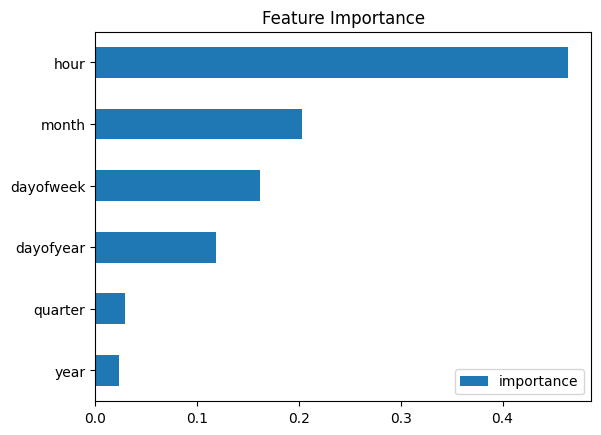

In [ ]:
f1.sort_values('importance').plot(kind='barh',title='Feature Importance')
plt.show()

In [ ]:
#Forecast on the test set
test['prediction']=reg.predict(x_test)

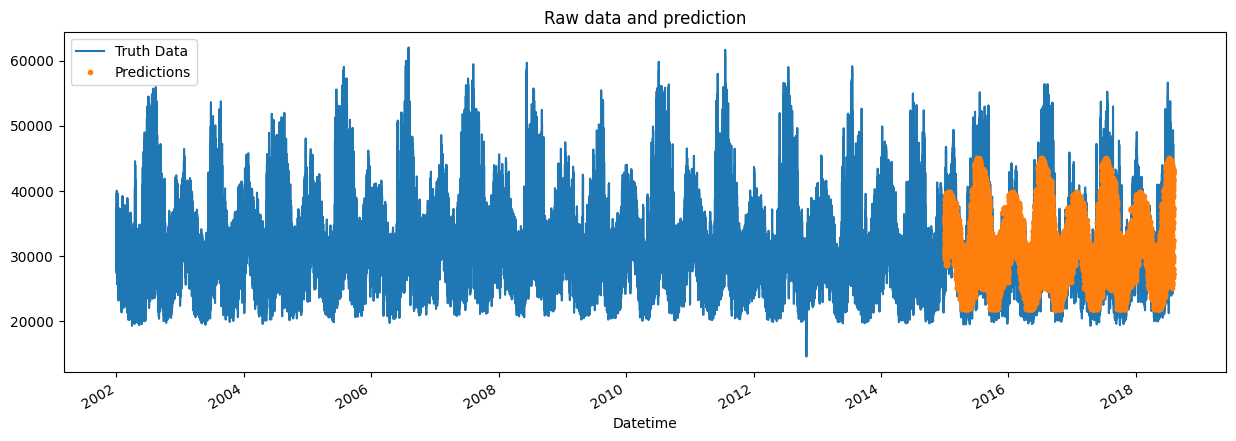

In [ ]:
df=df.merge(test[['prediction']],how='left',left_index=True, right_index=True)
ax=df[['PJME_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax,style='.')
plt.legend(['Truth Data','Predictions'])
ax.set_title('Raw data and prediction')
plt.show()


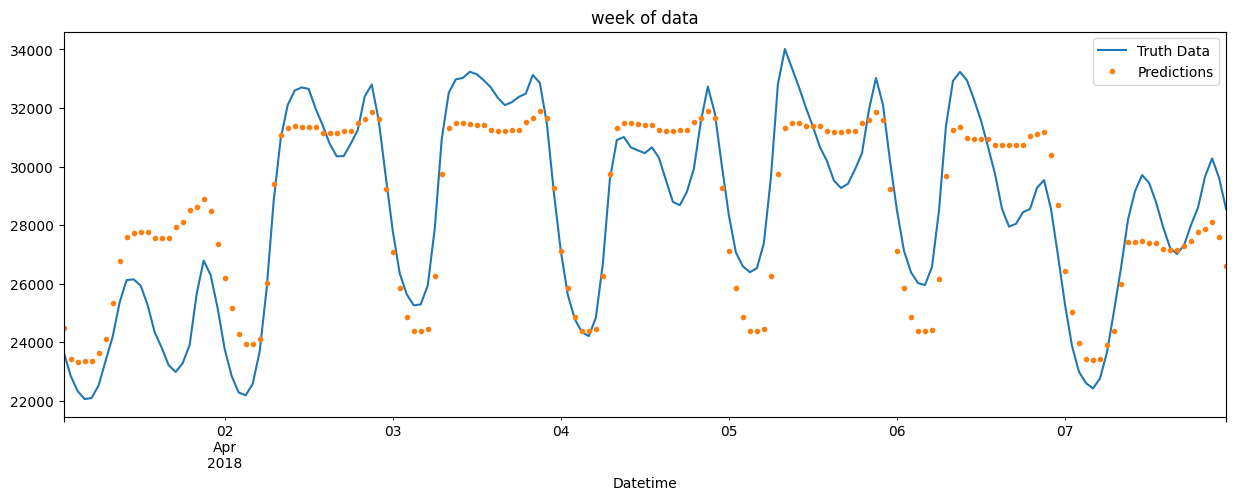

In [ ]:
ax=df.loc[(df.index > '04-01-2018')& (df.index < '04-08-2018')]['PJME_MW'].plot(figsize=(15,5), title='week of data')
df.loc[(df.index > '04-01-2018')& (df.index < '04-08-2018')]['prediction'].plot(style='.')
plt.legend(['Truth Data','Predictions'])
plt.show()


In [ ]:
#evaluation metirc
score = np.sqrt(mean_squared_error(test['PJME_MW'],test['prediction']))
print(f'RMSE Score on test set: {score:0.2f}')

RMSE Score on test set: 3741.03


In [ ]:
#look at best and worst predicted days
test['error']=np.abs(test[TARGET]-test['prediction'])
test['date']=test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(5)